In [1]:
# default_exp oscillator

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Oscillator

> This defines the Oscillator module which is used to generate waveforms


In [2]:
#hide
from nbdev.showdoc import *

## Generating Waveforms



First, let's define the different waveforms that the oscillator can generate

In [3]:
#export 
from myhdl import enum
osc_state = enum('SINE','SQUARE','TRIANGLE', 'SAWTOOTH', 'PWM', 'NOISE')

Each waveform is digitised using integer bit vectors. These must be defined from the following

In [4]:
#export
n_samps = 4096
bit_depth = 12
amp = 2**bit_depth - 1

### Sine Wave


In [5]:
#export
import math
from myhdl import intbv
sine = [intbv(int(amp * 0.5*(math.sin(2 * math.pi * x/n_samps)+1)),
              min=0, max=amp+1) for x in range(n_samps)]

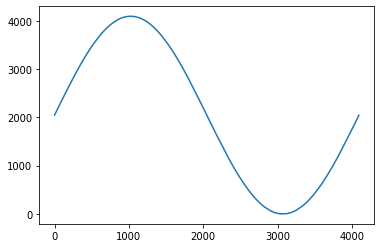

In [6]:
import matplotlib.pyplot as plt
def plot_waveform(x):
    plt.plot([i._val for i in x])

plot_waveform(sine)


### Square Wave



In [7]:
#export
square = [intbv(amp, min=0, max=amp+1) for _ in range(int(n_samps/2))] + \
[intbv(0, min=0, max=amp+1) for _ in range(int(n_samps/2))]

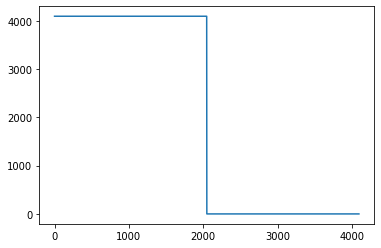

In [8]:
plot_waveform(square)

### Triangle Wave


In [9]:
#export
triangle = [intbv(n_samps//2 + int(2*amp/(n_samps) * math.fabs(x % (n_samps) - (n_samps)/2) - 2*amp/4), min=0, max=amp+1) for x in range(n_samps //4, 5 * n_samps //4)]

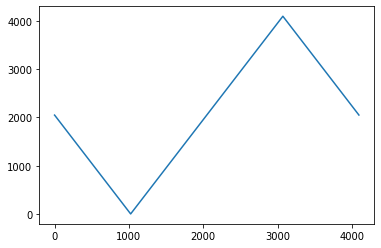

In [10]:
plot_waveform(triangle)

### Sawtooth Wave

In [11]:
#export
sawtooth = [intbv(int(amp * (x/n_samps - math.floor(0.5 + x/n_samps)) + amp//2), min=0, max=amp+1) for x in range(n_samps)]

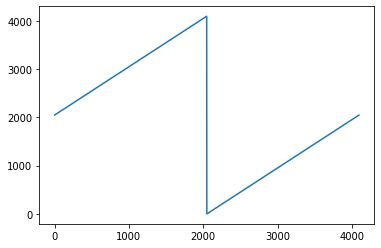

In [12]:
plot_waveform(sawtooth)

## Definein the Oscillator Module

In [89]:
# export
from myhdl import block, Signal, modbv, always_seq, always_comb, EnumItemType


@block
def Oscillator(z: Signal, state:EnumItemType,  clock: Signal, output_freq: int, reset: Signal, sampling_freq: int):

    count = Signal(modbv(0, min=0, max=2 ** 24))
    inc = Signal(intbv(0, min=0, max=2 ** 24))

    sine = [intbv(int(amp * 0.5*(math.sin(2 * math.pi * x/n_samps)+1)),
              min=0, max=amp+1) for x in range(n_samps)]
    square = [intbv(amp, min=0, max=amp+1) for _ in range(int(n_samps/2))] + \
    [intbv(0, min=0, max=amp+1) for _ in range(int(n_samps/2))]

    triangle = [intbv(n_samps//2 + int(2*amp/(n_samps) * math.fabs(x % (n_samps) - (n_samps)/2) - 2*amp/4), min=0, max=amp+1) for x in range(n_samps //4, 5 * n_samps //4)]
    sawtooth = [intbv(int(amp * (x/n_samps - math.floor(0.5 + x/n_samps)) + amp//2), min=0, max=amp+1) for x in range(n_samps)]

    @always_seq(clock.posedge, reset=reset)
    def output():
        count.next = count + inc
        addr = count[24:12]
        if state == osc_state.SINE:
            z.next = count
        elif state == osc_state.SQUARE:
            # z.next = square[addr]
            pass
        elif state == osc_state.TRIANGLE:
            # z.next = triangle[addr]
            pass
        elif state == osc_state.SAWTOOTH:
            # z.next = sawtooth[addr]
            pass
        elif state == osc_state.PWM:
            pass
        elif state == osc_state.NOISE:
            pass

    @always_comb
    def increment():
        inc_val = intbv(
            int(n_samps * output_freq * 2 ** 12 / sampling_freq), min=0, max=2 ** 24
        )
        print(inc_val)
        inc.val = inc_val

    return output


## Defining the Output Block

In [87]:
#export
from myhdl import always, delay, ResetSignal, instance, StopSimulation, traceSignals

ACTIVE_LOW, INACTIVE_HIGH = 0, 1
StopSimulation, 
def top():
    sampling_freq = 48000000
    clock = Signal(bool(0))
    reset = ResetSignal(bool(0), active=False, isasync=True)
    dout = Signal(intbv(0, min=0, max=256))
    state = osc_state.SINE
    output_freq = Signal(intbv(440, min=0, max=20000))
    
    HALF_PERIOD = delay(10)

    @always(HALF_PERIOD)
    def clock_gen():
        clock.next = not clock
        
    @instance
    def stimulus():
        reset.next = ACTIVE_LOW
        yield clock.negedge
        reset.next = INACTIVE_HIGH
        for i in range(12):
            yield clock.negedge
        raise StopSimulation

    @instance
    def monitor():
        print("enable count")
        yield reset.posedge
        while 1:
            yield clock.posedge
            yield delay(1)
            print(f"{dout.val}")

    channel  = Oscillator(dout, state, clock, output_freq, reset, sampling_freq)

    return clock_gen, stimulus, channel, monitor


In [88]:
# export
if __name__ == '__main__':
    inst = top()
    Simulation(inst).run()

enable count
00
00
00
00
00
00
00
00
00
00
00
00


In [74]:
traceSignals(top)

AttributeError: 'block' object has no attribute '__code__'

In [47]:
Simulation(inst).run()

<class 'myhdl.StopSimulation'>: No more events


0

In [31]:
from nbdev.export import notebook2script
notebook2script()


Converted 00_oscillator.ipynb.
Converted 01_oscillator_test.ipynb.
Converted index.ipynb.
